In [ ]:
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys
from tqdm import tqdm
import albumentations as A
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch.utils.data import Dataset, DataLoader
import helper

In [ ]:
csv_file = "/content/Human-Segmentation-Dataset-master/train.csv"
data_dir = "/content/ "
device = "cuda"
epochs = 40
lerning_rate = 0.003
image_size = 320
batch_size = 16
encoder = "timm-efficientnet-b0"
weights = "imagenet"

In [ ]:
df = pd.read_csv(csv_file)

In [ ]:
row = df.iloc[4]
image_path = row.images
mask_path = row.masks
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

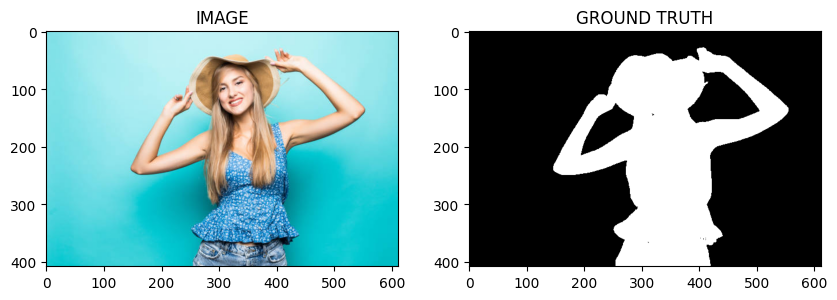

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)
ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [99]:
train_df , valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [101]:
def get_train_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
      ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(image_size, image_size)
      ], is_check_shapes=False)

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df , augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]
    image_path = row.images
    mask_path  = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 
    mask = np.expand_dims(mask, axis= -1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image)/255.0
      mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask

In [104]:
train_set = SegmentationDataset(train_df , get_train_augs())
Valid_set = SegmentationDataset(valid_df , get_valid_augs())

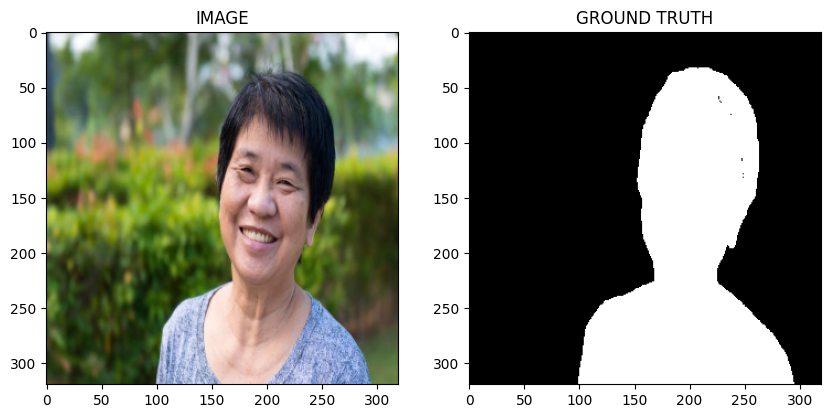

In [ ]:
index = 3
image,mask = train_set[index]
helper.show_image(image,mask)

In [108]:
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(Valid_set, batch_size)

In [112]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = encoder,
        encoder_weights = weights,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks= None):
   logits = self.arc(images)

   if masks != None :
     loss1 = DiceLoss(mode = "binary")(logits , masks)
     loss2 = nn.BCEWithLogitsLoss()(logits , masks)
     return logits , loss1+loss2

   return logits

In [ ]:
model = SegmentationModel()
model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = lerning_rate)

In [ ]:
def train_fn(dataloader, model, optimizer):
  model.train()

  total_loss = 0
  for images, masks in tqdm(dataloader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    _, loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss/len(dataloader)

In [ ]:
def eval_fn(dataloader, model):
  model.eval()

  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(device)
      masks = masks.to(device)

      optimizer.zero_grad()
      _, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss/len(dataloader)



In [117]:
best_valid_loss = np.Inf

for epoch in range(epochs):
  train_loss = train_fn(train_loader, model, optimizer)
  valid_loss = eval_fn(valid_loader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("Saved_Model")
    best_valid_loss = valid_loss

  print(f"Epoch : {epoch+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Saved_Model
Epoch : 1 Train_loss : 0.7108602523803711 Valid_loss : 0.839966282248497


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Saved_Model
Epoch : 2 Train_loss : 0.3880353589852651 Valid_loss : 0.35566794127225876


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Epoch : 3 Train_loss : 0.2955712685982386 Valid_loss : 0.38781749457120895


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


Saved_Model
Epoch : 4 Train_loss : 0.27876655558745067 Valid_loss : 0.34808463603258133


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Saved_Model
Epoch : 5 Train_loss : 0.22793058256308238 Valid_loss : 0.20301547273993492


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


Epoch : 6 Train_loss : 0.21384040117263795 Valid_loss : 0.24295201152563095


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch : 7 Train_loss : 0.23325616419315337 Valid_loss : 0.24138392880558968


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Epoch : 8 Train_loss : 0.1809080163637797 Valid_loss : 0.2795666642487049


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Epoch : 9 Train_loss : 0.19249172707398732 Valid_loss : 0.39852288365364075


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Epoch : 10 Train_loss : 0.17981265783309935 Valid_loss : 0.2227001003921032


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


Epoch : 11 Train_loss : 0.17128224670886993 Valid_loss : 0.24207419529557228


100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


Epoch : 12 Train_loss : 0.1812606434027354 Valid_loss : 0.2203141637146473


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Epoch : 13 Train_loss : 0.16770165413618088 Valid_loss : 0.21905335038900375


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


Epoch : 14 Train_loss : 0.1500015710790952 Valid_loss : 0.2098538614809513


100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


Epoch : 15 Train_loss : 0.14252515584230424 Valid_loss : 0.20484446734189987


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


Epoch : 16 Train_loss : 0.11025645484526952 Valid_loss : 0.21178258582949638


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Saved_Model
Epoch : 17 Train_loss : 0.1146912415822347 Valid_loss : 0.20177842676639557


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Saved_Model
Epoch : 18 Train_loss : 0.14134453137715658 Valid_loss : 0.16429873928427696


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch : 19 Train_loss : 0.14406883815924326 Valid_loss : 0.2126157395541668


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


Epoch : 20 Train_loss : 0.11902900959054628 Valid_loss : 0.17949704080820084


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch : 21 Train_loss : 0.09604463775952657 Valid_loss : 0.17124441638588905


100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


Epoch : 22 Train_loss : 0.10212945391734442 Valid_loss : 0.19952163472771645


100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


Epoch : 23 Train_loss : 0.14062832196553549 Valid_loss : 0.19279817678034306


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Epoch : 24 Train_loss : 0.12385740578174591 Valid_loss : 0.22944056242704391


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Epoch : 25 Train_loss : 0.12694696287314097 Valid_loss : 0.24902012199163437


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 26 Train_loss : 0.11557236015796661 Valid_loss : 0.23254450038075447


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


Epoch : 27 Train_loss : 0.11598626549045245 Valid_loss : 0.22894637286663055


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch : 28 Train_loss : 0.10218831201394399 Valid_loss : 0.24107307568192482


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


Epoch : 29 Train_loss : 0.09218099762996038 Valid_loss : 0.18958347663283348


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Epoch : 30 Train_loss : 0.09532216439644496 Valid_loss : 0.17296090722084045


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch : 31 Train_loss : 0.09625676348805427 Valid_loss : 0.2381012998521328


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch : 32 Train_loss : 0.0856451208392779 Valid_loss : 0.1925704888999462


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


Epoch : 33 Train_loss : 0.08094575703144073 Valid_loss : 0.19271178916096687


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


Epoch : 34 Train_loss : 0.07268550495306651 Valid_loss : 0.2136860489845276


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch : 35 Train_loss : 0.07359577715396881 Valid_loss : 0.18569421395659447


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


Epoch : 36 Train_loss : 0.07586144581437111 Valid_loss : 0.18960339948534966


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


Epoch : 37 Train_loss : 0.07365060696999232 Valid_loss : 0.19608832523226738


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


Epoch : 38 Train_loss : 0.07291865994532903 Valid_loss : 0.17282390594482422


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Epoch : 39 Train_loss : 0.1485022559762001 Valid_loss : 0.291913989931345


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

Epoch : 40 Train_loss : 0.10194213440020879 Valid_loss : 0.20234036073088646


In [ ]:
idx = 20
model.load_state_dict(torch.load("/content/best_model.pt"))
image, mask = Valid_set[idx]
logits_mask = model(image.to(device).unsqueeze(0)) 
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

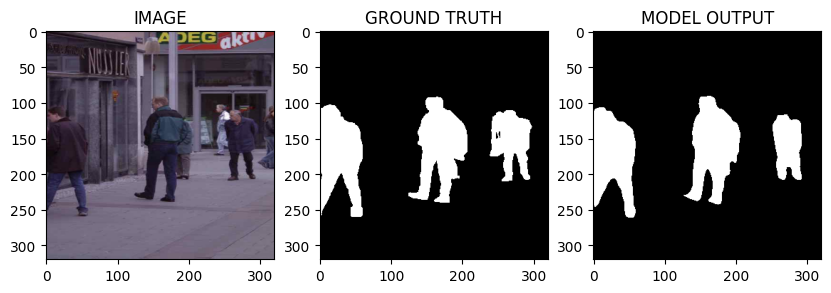

In [121]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

##### You can download the dataset using the following link
##### (https://github.com/VikramShenoy97/Human-Segmentation-Dataset)
